In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import math 
import ast
from tabulate import tabulate
from scipy.stats.stats import pearsonr
from scipy.stats import mode

def split_line(line):
    loss = float(line.split('loss: ')[1].split(',')[0])
    auc = float(line.split('auc: ')[1].split(',')[0])
    params = ast.literal_eval(line.split('params: ')[1])
    return [loss, auc, params]


def parse_file(files, sort_by_loss=True):
    results = []
    
    for filename in files:
        with open(filename, 'r') as fp:
            for line in fp:
                results.append(split_line(line.strip()))

    if sort_by_loss:
        results = sorted(results)
    else:
        results = sorted(results, key=lambda x: -x[1])

    lr = []
    reg = []
    width = []
    length = []
    dropout = []
    loss = []
    auc = []
    decay = []
    for result in results:
        loss.append(result[0])
        auc.append(result[1])
        lr.append(result[2]['lr'])
        reg.append(result[2]['reg'])
        decay.append(result[2]['decay'])
        dropout.append(result[2]['dropout'][0])
        width.append(result[2]['hidden_width'][0])
        length.append(len(result[2]['hidden_width']))
    
    loss = np.array(loss)
    auc = np.array(auc)
    lr = np.array(lr)
    decay = np.array(decay)
    reg = np.array(reg)
    width = np.array(width)
    length = np.array(length)
    dropout = np.array(dropout)
      
    results = {
        'loss': loss,
        'auc': auc,
        'lr': lr,
        #'decay': decay,
        'reg': reg,
        #'dropout': dropout,
        #'width': width,
        #'length': length,
    }
    
    print('')
    return results


def results_stats(results, top=1, relative=True):
    headers = ['metric', 'min', 'max', 'median', 'mean', 'std']    
    results_stats = []
    results_logstats = []
    
    top_results = dict()
    for i, key in enumerate(results):
        arr = results[key]
        if relative:
            idx = math.ceil(top*len(arr))
        else:
            idx = top
        arr = arr[:idx]
        top_results[key] = arr
        results_stats.append([key, arr.min(), arr.max(), np.median(arr), arr.mean(), arr.std()])
        
        if i == 0:
            samples = len(arr)
        
        if key in log_metrics:
            logarr = np.log10(arr)
            results_logstats.append([key, logarr.min(), logarr.max(), 
                                     np.median(logarr), logarr.mean(), logarr.std()])
            
    print('# samples = %d/%d' % (samples, len(results[key])))
    print (tabulate(results_stats, headers=headers, numalign="right", floatfmt=".10f"))
    print('\n\nlog metrics')
    print (tabulate(results_logstats, headers=headers, numalign="right", floatfmt=".10f"))
    
    return results_stats, top_results


def plot_hist(results):
    plt.figure(figsize=(12, 12))
    ncol = 3
    nrow = math.ceil(len(results) / ncol) 
        
    for i, key in enumerate(results):
        plt.subplot(nrow, ncol, i + 1)
        if key in log_metrics:
            arr = np.log10(results[key])
            label = 'log' + key
        else:
            arr = results[key]
            label = key
        
        max = arr.max()
        min = arr.min()
        bins = np.linspace(min, max, 15)
        plt.hist(arr, bins=bins)
        plt.xlabel(label)
        plt.ylabel('freq')
        
        
def print_best(results, k=1):
    best_result = []
    headers = []
    
    for i in range(k):
        best_result.append([])
        for key in results:
            if key in log_metrics:
                best_result[-1] += [np.log10(results[key][i])]
                if i == 0:
                    headers += ['log' + key]
            else:
                best_result[-1] += [results[key][i]]
                if i == 0:
                    headers += [key]

    print('\nbest models')
    print (tabulate(best_result, headers=headers, numalign="right", floatfmt=".6f"))
    print()
    
    
def plot_scatter(results, metric='loss'):
    plt.figure(figsize=(12, 12))
    ncol = 3
    nrow = math.ceil(len(results) / ncol) 
    
    count = 1
    for key in results:
        if key != metric:
            plt.subplot(nrow, ncol, count)
            if key in log_metrics:
                arr = np.log10(results[key])
                label = 'log' + key
            else:
                arr = results[key]
                label = key

            plt.scatter(arr, results[metric])
            plt.xlabel(label)
            plt.ylabel(metric)
            count += 1
        
        
def get_model_name(results, top=5):
    names = []
    for i in range(top):
        name = 'model.' \
            + 'auc:%.6f.' % results['auc'][i] \
            + 'lr:%.6f.' % results['lr'][i] \
            + 'reg:%.6f.' % results['reg'][i] 
        names += [name]
        
    return names


def compare_plots(results, keys, top=10):
    plt.figure(figsize=(15, 6))
    marker_size = 20
    
    # loss
    plt.subplot(1, 2, 1)
    colors = results['loss'][:top]
    x_scatter = results[keys[0]][:top]
    xlabel = keys[0]
    if keys[0] in log_metrics:
        x_scatter = np.log10(x_scatter)
        xlabel = 'log' + xlabel
    
    y_scatter = results[keys[1]][:top]
    ylabel = keys[1]
    if keys[1] in log_metrics:
        y_scatter = np.log10(y_scatter)
        ylabel = 'log' + ylabel
    
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('loss')
    
    # auc
    plt.subplot(1, 2, 2)
    colors = results['auc'][:top]
    plt.scatter(x_scatter, y_scatter, marker_size, cmap='inferno', c=colors)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('auc')

    
def topology_hist(results, metric='loss'):
    keys = ['width', 'length']
    plt.figure(figsize=(16, 6))
    max = results[metric].max()
    min = results[metric].min()
    bins = np.linspace(min, max, 7)    
    for i, key in enumerate(keys):
        for value in np.unique(results[key]):
            plt.subplot(1, 2, i + 1)
            plt.hist(results[metric][results[key] == value], label=key+'='+str(value), bins=bins)
        plt.xlabel(metric)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
        plt.xlim([0.99*min, 1.01*max])
        
        if i == 0:
            plt.ylabel('freq')
            
log_metrics = ['lr', 'decay', 'reg']

In [21]:
files = ['../results.log']   
results = parse_file(files, sort_by_loss=False)

top = 20
print('Correlation loss x AUC: (%.6f, %.6e)' % pearsonr(results['auc'], results['loss']))
print_best(results, top)
_, top_results = results_stats(results, top, relative=False)


Correlation loss x AUC: (-0.681106, 1.127879e-50)

best models
    loss       auc      loglr     logreg
--------  --------  ---------  ---------
0.175443  0.987883  -2.480830  -2.809233
0.147518  0.987867  -2.563818  -2.713184
0.173750  0.987620  -2.528479  -2.749916
0.164648  0.987583  -2.481337  -2.823705
0.169765  0.987489  -2.569065  -2.964229
0.158643  0.987429  -2.358062  -2.859803
0.152395  0.987322  -2.496265  -2.653031
0.146596  0.987147  -2.389207  -2.678412
0.145500  0.986989  -2.296020  -2.880992
0.187652  0.986495  -1.802476  -4.421481
0.160016  0.986447  -2.502110  -2.805344
0.151932  0.986436  -2.549107  -2.538775
0.187527  0.986410  -2.666827  -2.476545
0.160768  0.986364  -2.482816  -2.812867
0.169610  0.986323  -2.350709  -2.576313
0.174789  0.986286  -1.745374  -4.568024
0.160941  0.986256  -2.522491  -2.752381
0.152379  0.986205  -1.788666  -3.876941
0.164539  0.986178  -1.806480  -3.725522
0.153141  0.986158  -2.390380  -2.582681

# samples = 20/362
metric        

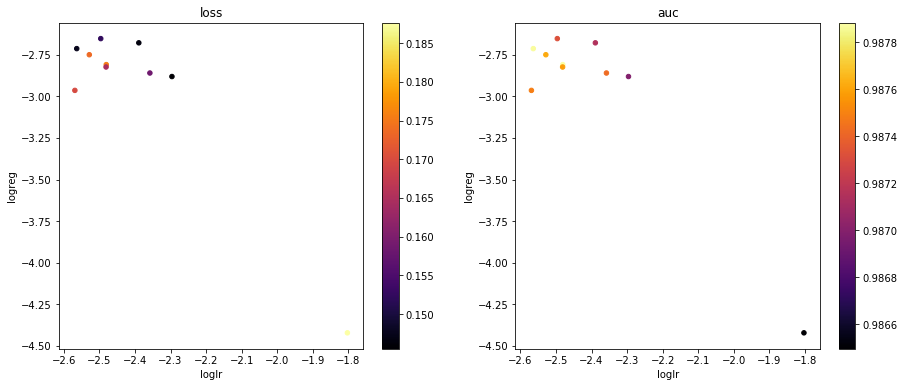

In [22]:
compare_plots(results, ['lr', 'reg'], 10)

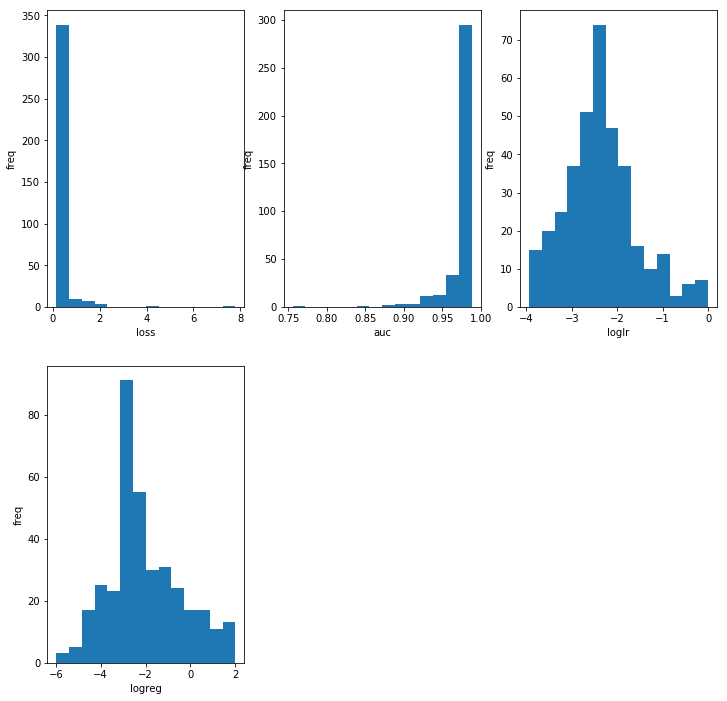

In [23]:
plot_hist(results)

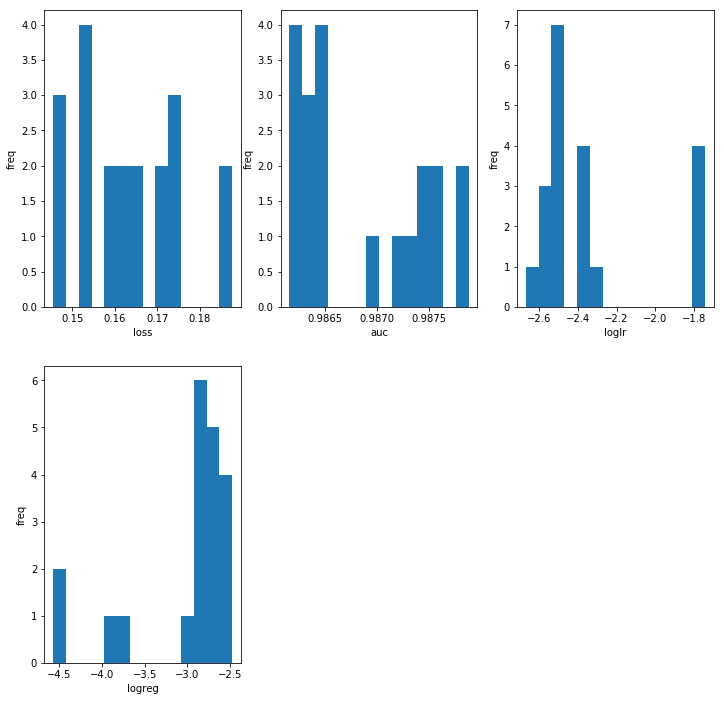

In [24]:
plot_hist(top_results)

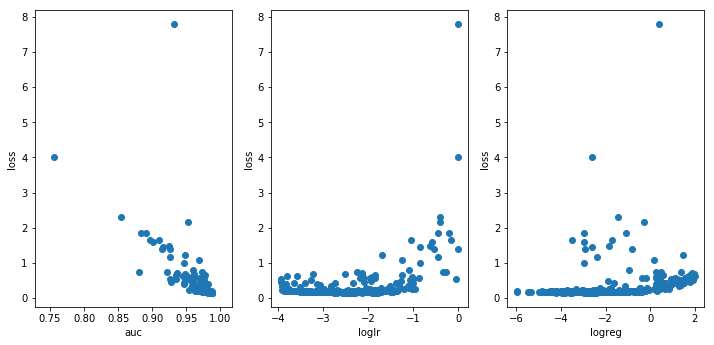

In [7]:
plot_scatter(results, 'loss')

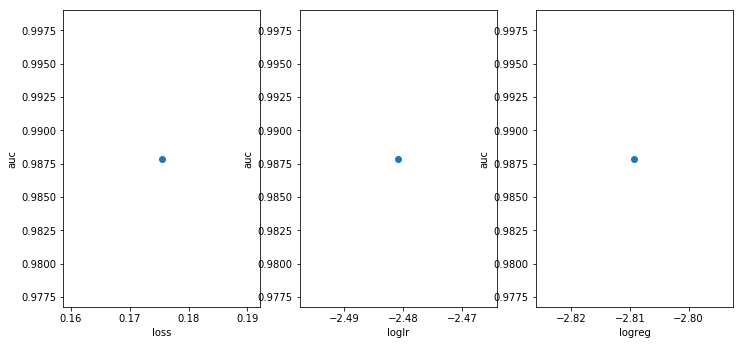

In [8]:
plot_scatter(top_results, 'auc')

../history/model.auc:0.987883.lr:0.003305.reg:0.001552.pickle


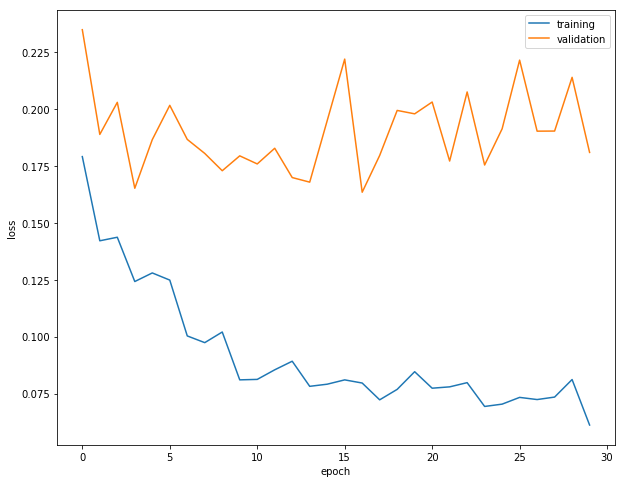

In [9]:
def plot_evolution(scores_train, scores_val, metric, loc=None):
    plt.plot(scores_train[metric], label='training')
    plt.plot(scores_val[metric], label='validation')
    plt.xlabel('epoch')
    plt.ylabel(metric)
    if loc is None:
        plt.legend(loc="upper right")
    else:
        plt.legend(loc=loc)

import pickle


filename = '../history/' + get_model_name(results, top)[0] + 'pickle'
print(filename)
with open(filename, 'rb') as handle:
    [scores_train, scores_val] = pickle.load(handle)
plot_evolution(scores_train, scores_val, 'loss')

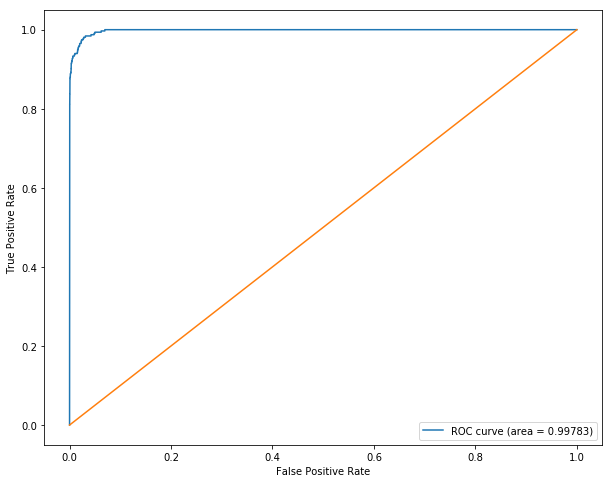

In [19]:
def plot_roc(model, x, y):
    if params['weights'] is not None:
        weights = np.empty_like(y)
        weights[y == 0] = params['weights'][0]
        weights[y == 1] = params['weights'][1]
    else:
        weights = None
        
    y_score = model.predict(x) 
    fpr, tpr, _ = roc_curve(y, y_score, sample_weight=weights)
    roc_auc = roc_auc_score(y, y_score, sample_weight=weights)
    plt.plot(fpr, tpr,label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot(np.arange(0, 1.1, 0.1),np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
def classic_mlp(params, summary=False):
    inputs = Input(shape=(input_dim,))
    x = inputs
    for i in range(len(params['hidden_width'])):
        x = Dense(
            units=params['hidden_width'][i],
            kernel_regularizer=params['regularizer'],
            kernel_initializer=params['initializer'])(x)
        if params['batchnorm']:
            x = BatchNormalization()(x)
        x = Activation(params['hidden_activation'])(x)
        x = Dropout(params['dropout'][i])(x)

    x = Dense(units=1, kernel_regularizer=params['regularizer'])(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'])

    return model

def get_data_weights(weight_dict, y):
    if weight_dict is None:
        weights = None
    else:
        weights = np.empty_like(y)
        weights[y == 0] = weight_dict[0]
        weights[y == 1] = weight_dict[1]

    return weights

from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, log_loss

nlayers=3
params = {
        'lr': 0.,
        'decay': 0.0,
        'reg': 0.,
        'loss': 'binary_crossentropy',
        'hidden_width': [100]*nlayers,
        'hidden_activation': 'relu',
        'regularizer': l2(0.0015515536),
        'weight_dict': [],
        'train_weights': [],
        'val_weights': [],
        'dropout': [0.5]*nlayers,
        'optimizer': Adam(lr=0.0033049896, decay=0.),
        'initializer': 'he_normal',
        'batchnorm': True,
        'batch_size': 1024,
        'epochs': 30,
        'nruns': 1000,
        'save_history': True
    }

data = np.load('../data/creditcard_train.npz')
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']
input_dim = x_train.shape[1]

params['weight_dict'] = {
        0:len(y_train) / np.sum(1 - y_train),
        1:len(y_train) / np.sum(y_train)
    }
params['train_weights'] = get_data_weights(params['weight_dict'], y_train)
params['val_weights'] = get_data_weights(params['weight_dict'], y_val)

params['weights'] = params['train_weights']
model = classic_mlp(params)
model.load_weights('../model/model.auc:0.987883.lr:0.003305.reg:0.001552.hdf5')
plot_roc(model, x_train, y_train)

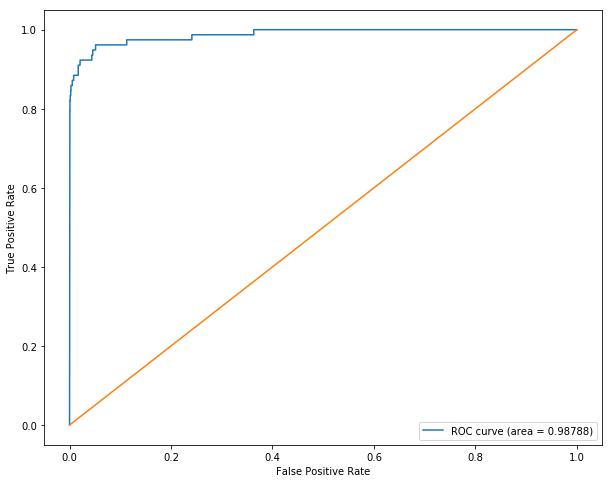

In [20]:
params['weights'] = params['val_weights']
plot_roc(model, x_val, y_val)